In [1]:
import os
import cv2
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from collections import Counter
import kagglehub

In [2]:
dataset_path = kagglehub.dataset_download('ashishsaxena2209/animal-image-datasetdog-cat-and-panda')
print('Dataset download complete.')

Dataset download complete.


In [4]:
def load_images_from_category(base_path, category, label, img_size, max_images):
    data = []
    category_path = os.path.join(base_path, category)
    image_files = os.listdir(category_path)[:max_images]

    for img_name in tqdm(image_files, desc=f"Loading {category}"):
        img_path = os.path.join(category_path, img_name)
        img = cv2.imread(img_path)

        if img is None:
            continue

        try:
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            resized = cv2.resize(gray, (img_size, img_size))
            data.append([resized, label])
        except Exception:
            continue

    return data

# Main logic
dataset_dir = os.path.join(dataset_path, 'animals')
categories = ['cats', 'dogs', 'panda']
img_size = 32
images_per_class = 1000

train_data = []

for label, category in enumerate(categories):
    category_data = load_images_from_category(dataset_dir, category, label, img_size, images_per_class)
    train_data.extend(category_data)

np.random.shuffle(train_data)


Loading panda: 100%|██████████| 1000/1000 [00:05<00:00, 174.05it/s]


In [11]:
# Separate features and labels
X = np.array([item[0] for item in train_data])
y = np.array([item[1] for item in train_data])

# Split into 5 equal parts
X_parts = np.array_split(X, 5)
y_parts = np.array_split(y, 5)

# Generate train/val splits
folds = [
    {
        'train': (np.concatenate([X_parts[j] for j in range(5) if j != i]),
                  np.concatenate([y_parts[j] for j in range(5) if j != i])),
        'val': (X_parts[i], y_parts[i])
    }
    for i in range(5)
]

# Print fold info
for i, fold in enumerate(folds):
    print(f"Fold {i+1}: {len(fold['train'][0])} train samples, {len(fold['val'][0])} val samples")


Fold 1: 2400 train samples, 600 val samples
Fold 2: 2400 train samples, 600 val samples
Fold 3: 2400 train samples, 600 val samples
Fold 4: 2400 train samples, 600 val samples
Fold 5: 2400 train samples, 600 val samples


In [12]:
def l1_distance(a, b):
    return np.sum(np.abs(a - b))

def l2_distance(a, b):
    return np.sqrt(np.sum((a - b) ** 2))

In [13]:
def knn_predict(X_train, y_train, x_test, k=3, distance_fn=l2_distance):
    distances = []

    for i in range(len(X_train)):
        dist = distance_fn(X_train[i], x_test)
        distances.append((dist, y_train[i]))

    # Sort by distance and get top-k nearest labels
    distances.sort(key=lambda x: x[0])
    k_nearest_labels = [label for (_, label) in distances[:k]]

    # Majority vote
    most_common = Counter(k_nearest_labels).most_common(1)
    return most_common[0][0]


In [14]:
# Use first fold
X_train, y_train = folds[0]['train']
X_val, y_val = folds[0]['val']

# Predict on a few validation samples using L2 distance
correct = 0
k = 5
for i in range(20):  # Limiting to 20 samples for speed
    pred = knn_predict(X_train, y_train, X_val[i], k=k, distance_fn=l2_distance)
    if pred == y_val[i]:
        correct += 1

print(f"Accuracy on first 20 val samples: {correct}/20 = {correct / 20:.2f}")


Accuracy on first 20 val samples: 11/20 = 0.55


In [15]:
def evaluate_knn_cv(folds, k=5, distance_fn=l2_distance):
    fold_accuracies = []

    for i, fold in enumerate(folds):
        X_train, y_train = fold['train']
        X_val, y_val = fold['val']

        correct = 0

        for j in range(len(X_val)):
            pred = knn_predict(X_train, y_train, X_val[j], k=k, distance_fn=distance_fn)
            if pred == y_val[j]:
                correct += 1

        accuracy = correct / len(y_val)
        fold_accuracies.append(accuracy)
        print(f"Fold {i + 1} Accuracy: {accuracy:.4f}")

    avg_accuracy = np.mean(fold_accuracies)
    print(f"\nAverage Cross-Validation Accuracy: {avg_accuracy:.4f}")
    return fold_accuracies, avg_accuracy


In [33]:
# Ensure proper structure of folds
folds = [
    {
        'train': (
            np.concatenate([X_parts[j] for j in range(5) if j != i]),
            np.concatenate([y_parts[j] for j in range(5) if j != i])
        ),
        'val': (X_parts[i], y_parts[i])
    }
    for i in range(5)
]
# Running evaluation with L2 distance (Euclidean)
print("Evaluating with L2 distance:")
l2_accuracies, avg_l2_accuracy = evaluate_knn_cv(folds, k=5, distance_fn=l2_distance)

# Running evaluation with L1 distance (Manhattan)
print("\nEvaluating with L1 distance:")
l1_accuracies, avg_l1_accuracy = evaluate_knn_cv(folds, k=5, distance_fn=l1_distance)


Evaluating with L2 distance:
Fold 1 Accuracy: 0.4267
Fold 2 Accuracy: 0.4700
Fold 3 Accuracy: 0.4517
Fold 4 Accuracy: 0.4767
Fold 5 Accuracy: 0.4567

Average Cross-Validation Accuracy: 0.4563

Evaluating with L1 distance:
Fold 1 Accuracy: 0.3400
Fold 2 Accuracy: 0.3783
Fold 3 Accuracy: 0.3333
Fold 4 Accuracy: 0.3367
Fold 5 Accuracy: 0.3667

Average Cross-Validation Accuracy: 0.3510


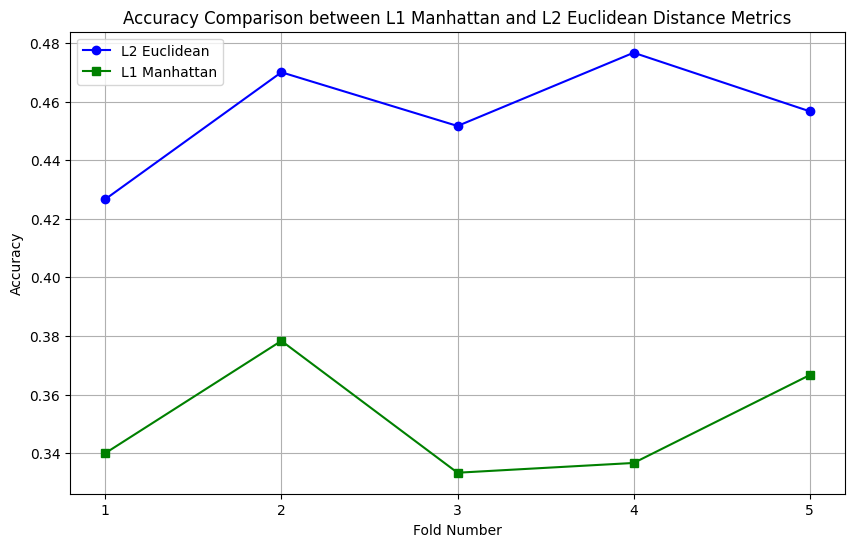

In [35]:
import matplotlib.pyplot as plt

# Assuming you have the accuracies for L1 and L2 stored in l1_accuracies and l2_accuracies

# Generate fold numbers (1 to 5)
folds_range = [i+1 for i in range(len(l1_accuracies))]

# Plot the accuracies
plt.figure(figsize=(10, 6))

# Plot L2 Euclidean accuracy
plt.plot(folds_range, l2_accuracies, label="L2 Euclidean", marker='o', color='blue')

# Plot L1 Manhattan accuracy
plt.plot(folds_range, l1_accuracies, label="L1 Manhattan", marker='s', color='green')

# Labels and Title
plt.xlabel('Fold Number')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison between L1 Manhattan and L2 Euclidean Distance Metrics')
plt.xticks(folds_range)  # Ensure each fold is labeled on the x-axis
plt.grid(True)

# Show legend
plt.legend()

# Show the plot
plt.show()


Top 5 Predictions from Fold 0:
Sample 1: Predicted = dog, True Label = cat
Sample 2: Predicted = cat, True Label = cat
Sample 3: Predicted = cat, True Label = dog
Sample 4: Predicted = panda, True Label = panda
Sample 5: Predicted = cat, True Label = cat


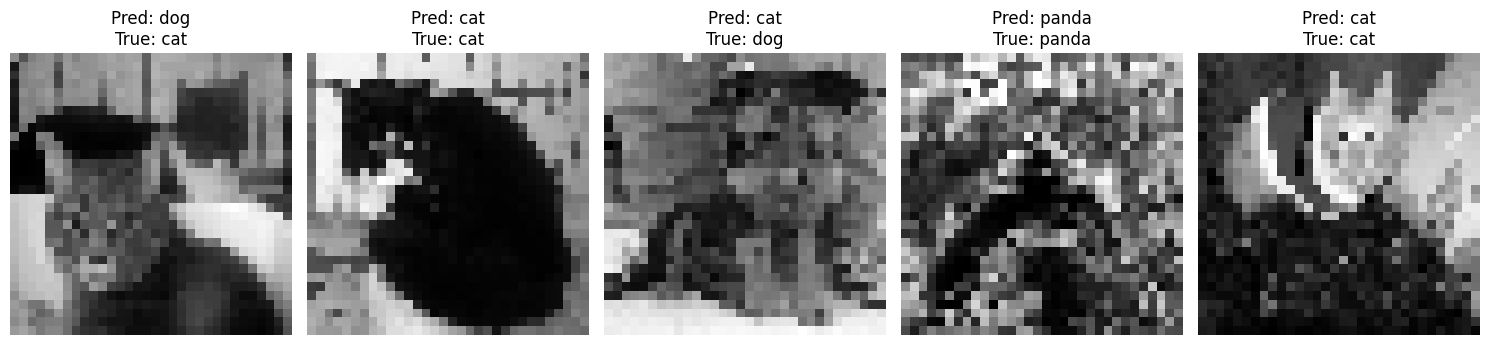

In [40]:
import matplotlib.pyplot as plt

# Label-to-name mapping
label_map = {0: "cat", 1: "dog", 2: "panda"}

# Extract the first fold's data
X_train, y_train = folds[0]['train']
X_val, y_val = folds[0]['val']

# Number of top predictions to show
top_n = 5

# List to store top 5 predictions (predicted label, true label, image)
top_predictions = []

# Predict on the first few validation samples
for i in range(top_n):
    pred = knn_predict(X_train, y_train, X_val[i], k=5, distance_fn=l2_distance)  # or use l1_distance
    true_label = y_val[i]
    top_predictions.append((pred, true_label, X_val[i]))

# Display the top 5 predictions with images
print("Top 5 Predictions from Fold 0:")

fig, axes = plt.subplots(1, top_n, figsize=(15, 5))

for i, (pred, true_label, img) in enumerate(top_predictions):
    pred_name = label_map[pred]
    true_name = label_map[true_label]

    # Display the image
    axes[i].imshow(img, cmap='gray')
    axes[i].axis('off')
    axes[i].set_title(f"Pred: {pred_name}\nTrue: {true_name}")

    print(f"Sample {i+1}: Predicted = {pred_name}, True Label = {true_name}")

plt.tight_layout()
plt.show()


# Discussion:
we implemented a k-Nearest Neighbors (k-NN) classifier using both L1 (Manhattan) and L2 (Euclidean) distance metrics and evaluated their performance using 5-fold cross-validation. The k-NN classifier is a simple, intuitive model that makes predictions based on the majority vote of the k closest training samples, though it can become computationally expensive for large datasets. The evaluation results show that the k-NN classifier performs better using L2 (Euclidean) distance compared to L1 (Manhattan) distance on this animal image dataset. With L2 distance, the fold accuracies range from 42.7% to 47.7%, averaging 45.6%, while L1 distance yields consistently lower fold accuracies between 33.3% and 37.8%, averaging 35.1%. This suggests that the Euclidean distance is more effective for capturing similarity in this dataset, likely because it better accounts for overall pixel intensity differences in image features. In contrast, the Manhattan distance may be too simplistic for this type of high-dimensional image data, where subtle variations are crucial for distinguishing between classes like cats, dogs, and pandas. Thus, for image-based classification tasks, especially with raw pixel values, L2 distance tends to be the more suitable choice.